## Wikipedia Time Series Analysis
This project is a multiple time series project from Kaggle, with the goal to predict Wikipedia web views for 145k different pages. Training data ranges from July 2015 to December 2016, and predictions range from January 2017 to March 2017. This notebook is 4 part:

1. Data exploration
2. ARIMA Model
3. Facebook's Prophet Model
4. Conclusion

### 1. Data exploration
This section explores patterns in the training data and implements some preprocessing for visualization:
1. Parse out language, article, and access type from the URL
2. Look at distribution of pages across languages
3. Plot total views per language 
4. Plot sample of random web pages per language
5. Plot top 5 pages per language
6. Look at patterns by day of week, language 

#### Insights:
- Language frequency: English and Japanese articles are the highest frequency in the dataset
- Page views by language: English articles by far have the highest number of page views above all other languages, despite the fact that there are a close number of Japanese pages in the dataset
- Page view behavior: Many articles have huge spikes in page views at different points in time; in our sample of random pages per language, few pages have a consistent, seemingly predictable or cyclic number of views over time
- Top sites: Even among top sites per language, there are large outliers in page views. Top sites from some languages seem more predictable than others; i.e. Spanish top sites have a more consistent pattern than Chinese sites
- Main page: For each language, the top site is the Wikipedia main page
- Monthly trends: The second half of 2015 saw many more page views than the first 6 months; no discernable reasons why there was a large spike in August for some languages. Throughout August, Mondays were the highest frequency days
- Day of the week: Sunday and Monday are the most popular days of the week, while Friday and Saturday are the least popular
- Day of the month: Visits to not seem to vary widely based on the day of the month

In [1]:
#data manipulation and plotting
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import seaborn as sns
import itertools

#time series modeling
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split
from pmdarima.metrics import smape
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics

#utilities
from tqdm import tqdm
import warnings
import os
#ignore the warnings about not having different language fonts available 
warnings.filterwarnings(action='ignore') 
from datetime import date
import holidays

import logging
#logger = logging.getLogger('ftpuploader')
logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [2]:
#load data and downcast to integers
orig_train = pd.read_csv('/Users/christinejiang/Documents/Python/data/train_1.csv')
key = pd.read_csv('/Users/christinejiang/Documents/Python/data/key_1.csv')
submission = pd.read_csv('/Users/christinejiang/Documents/Python/data/sample_submission_1.csv')
second_train = pd.read_csv('/Users/christinejiang/Documents/Python/data/train_2.csv')

train = orig_train.fillna(0)
for col in train.columns[1:]:
    train[col] = pd.to_numeric(train[col], downcast='integer')

In [3]:
def find_lang(page):
    match = re.search('[a-z][a-z].wikipedia.org', page)
    if match:
        return match.group(0)[0:2]
    return 'na'

def find_article(page):
    match = re.search('[a-z][a-z].wikipedia.org.', page)
    if match:
        article_end = match.start()-1
        return(page[0:article_end])
    return 'na'

def find_access(page):
    match = re.search('.*.wikipedia.org.', page)
    if match:
        access_start = match.end()
        return(page[access_start:])
    return 'na'

train['Language'] = train['Page'].map(find_lang)
train['Article'] = train['Page'].map(find_article)
train['Access'] = train['Page'].map(find_access)

#### Number of pages per language

In [11]:
dates = train.iloc[:,1:551]
labels = train[['Article','Language','Access','Page']]
newtrain = pd.concat([labels, dates], axis=1)

display(newtrain.head(2))
frequency = newtrain['Language'].value_counts().sort_values(ascending=False)
print(f'Number of pages per language: \n{frequency}')

,Article,Language,Access,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1,zh,all-access_spider,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,...,32,63,15,26,14,20,22,19,18,20
1,2PM,zh,all-access_spider,2PM_zh.wikipedia.org_all-access_spider,11,14,15,18,11,13,...,17,42,28,15,9,30,52,45,26,20


Number of pages per language: 
en    24108
ja    20431
de    18547
na    17855
fr    17802
zh    17229
ru    15022
es    14069
Name: Language, dtype: int64


#### Total page views per language

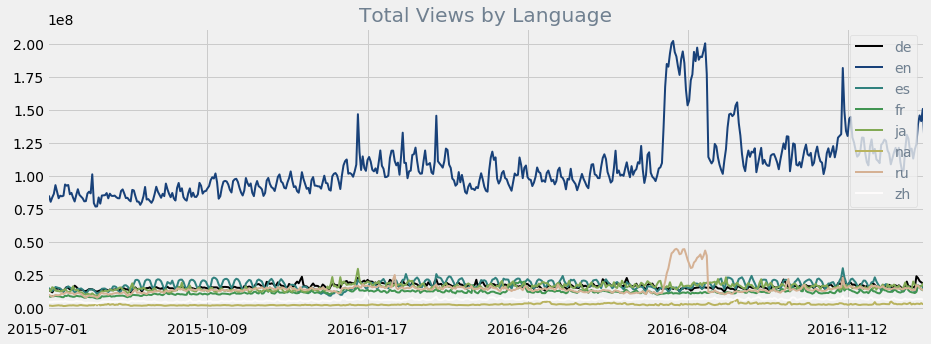

In [94]:
def plot_groups(df, groupby):
    plt.style.use('fivethirtyeight')
    group = df.groupby(groupby).sum().reset_index()
    transpose = group.T
    transpose = transpose.rename(columns=transpose.iloc[0]).drop(transpose.index[0])
    figure = transpose.plot(figsize=(14,5), use_index=True, colormap="gist_earth", lw=2)
    title=plt.title('Total Views by '+str(groupby), color='slategray')
    plt.legend(loc='upper left')
    plt.setp(plt.legend().get_texts(), color='slategray')
    return transpose

transposed = plot_groups(newtrain.iloc[:,:-1], 'Language')

#### Random selection of pages per language

Indices chosen: [ 955 1092  554]


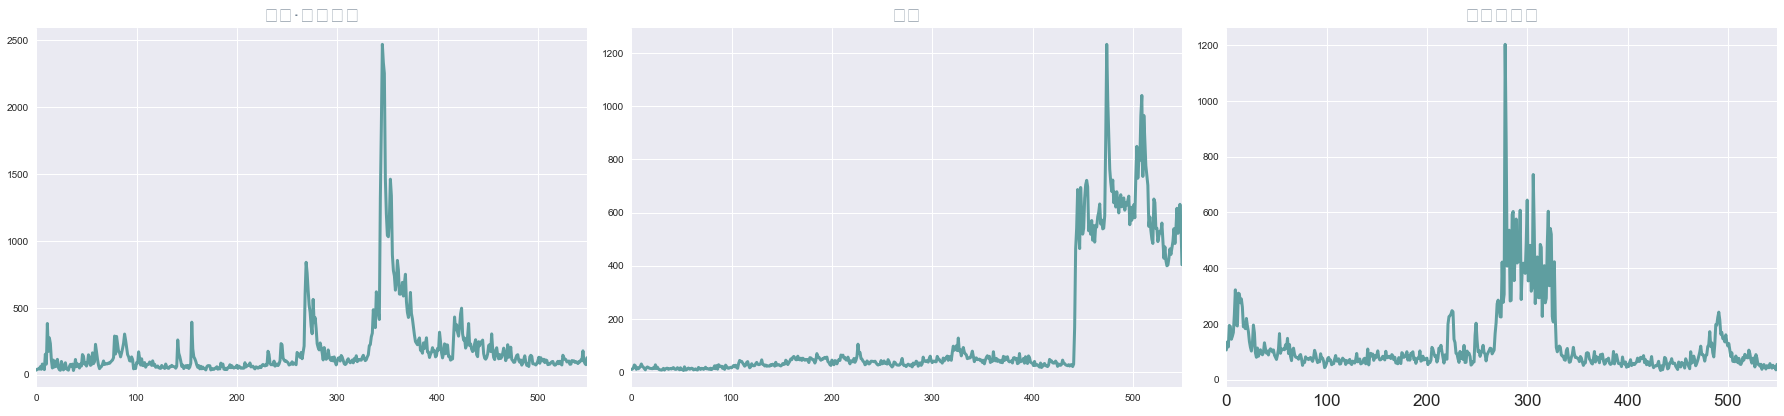

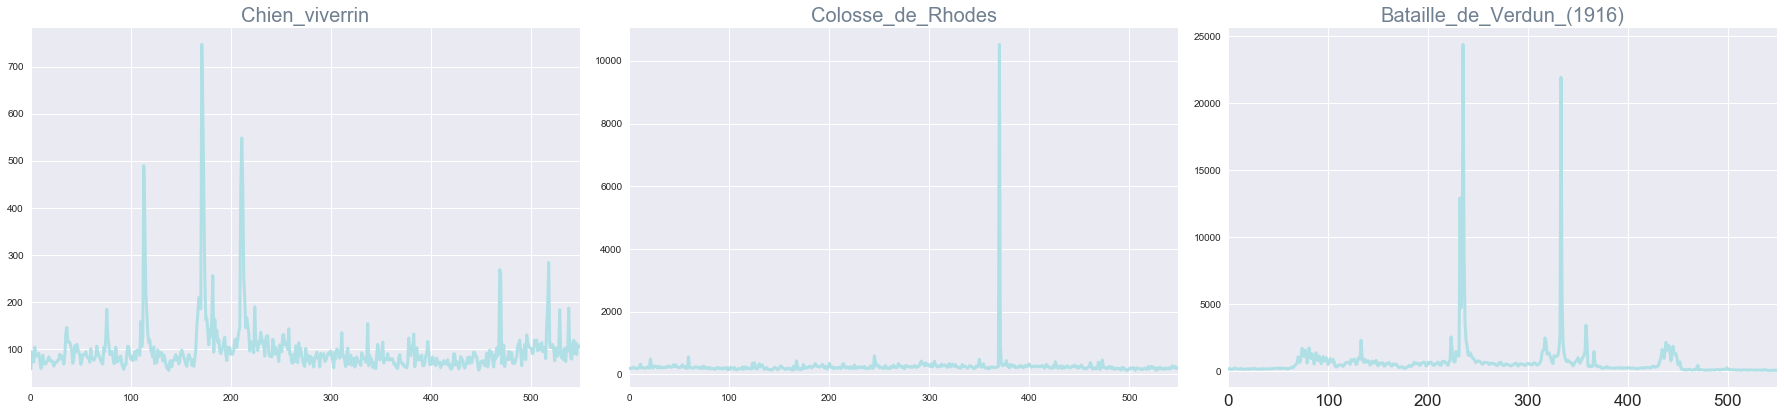

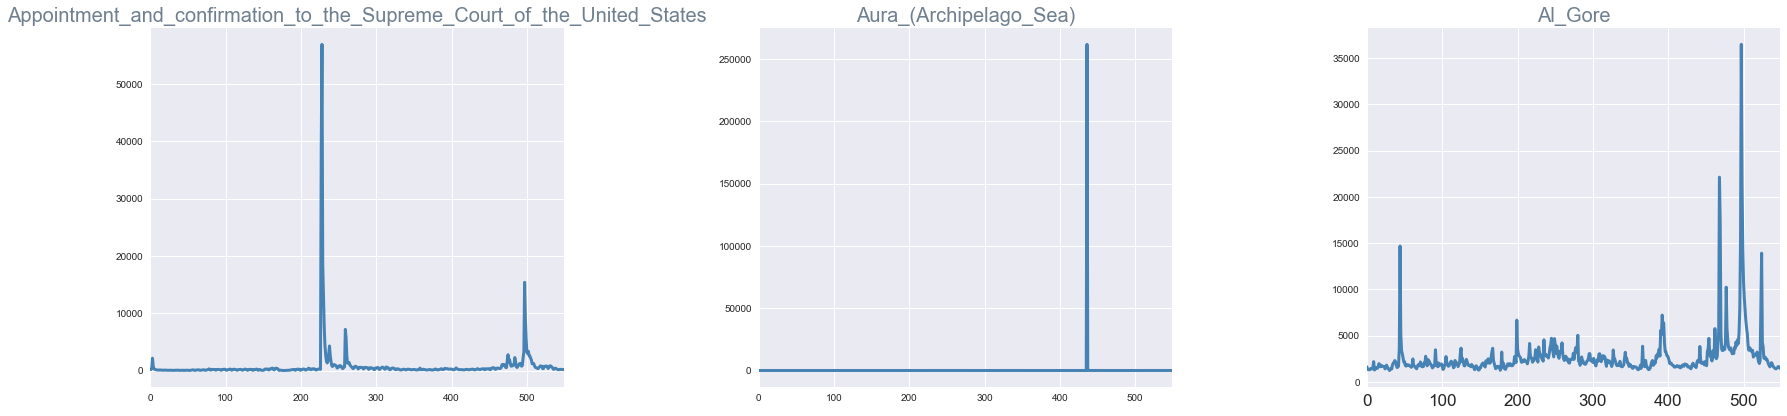

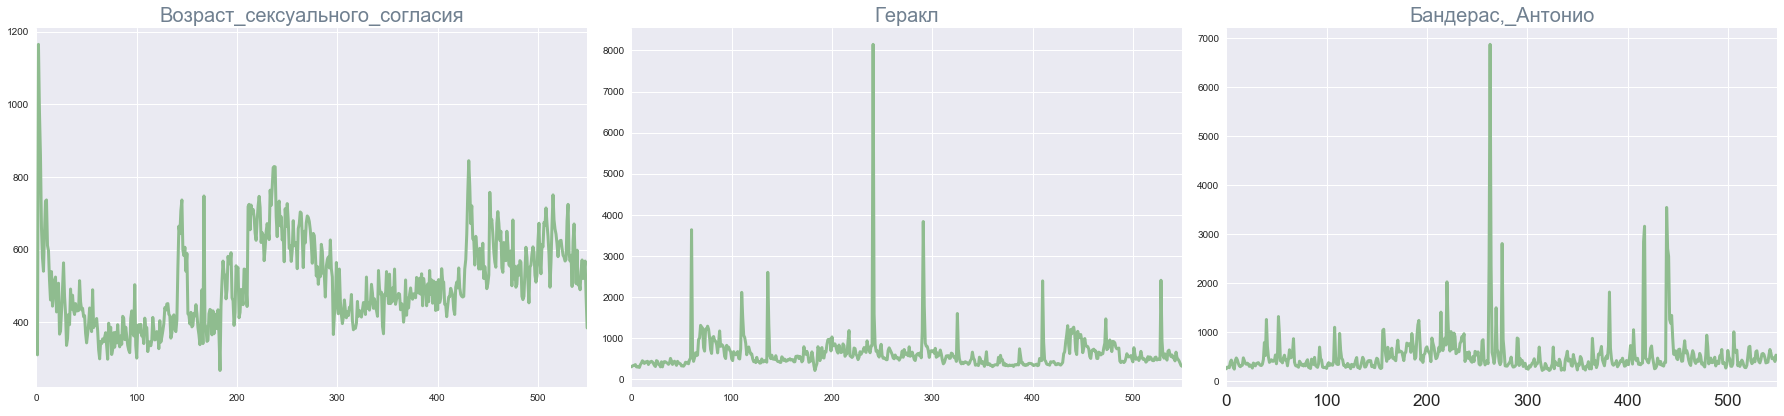

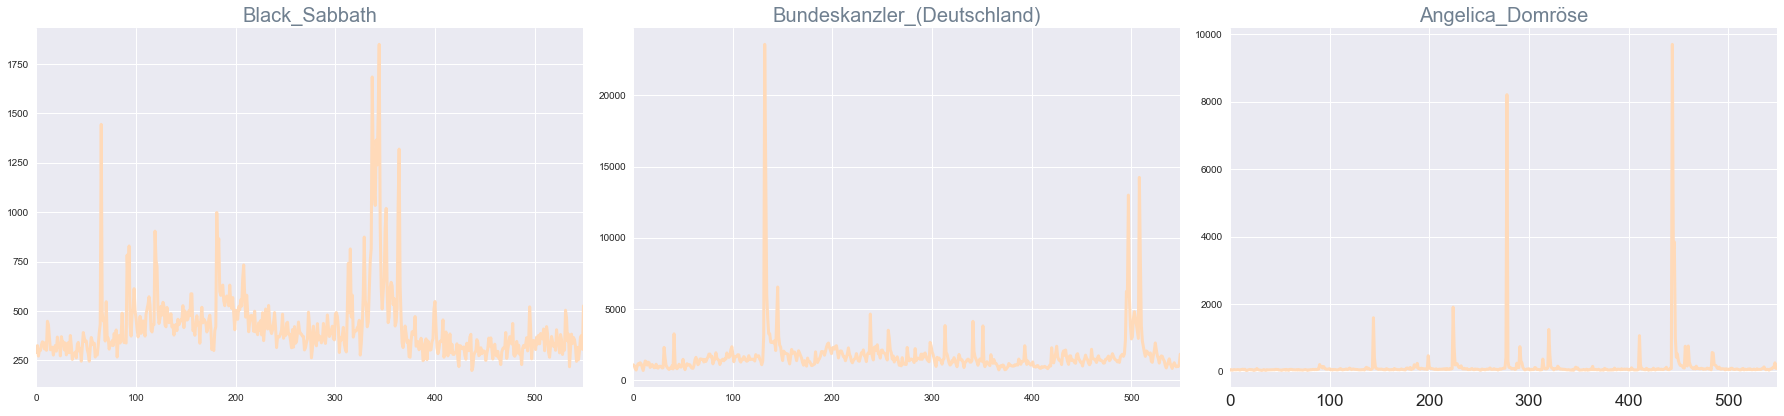

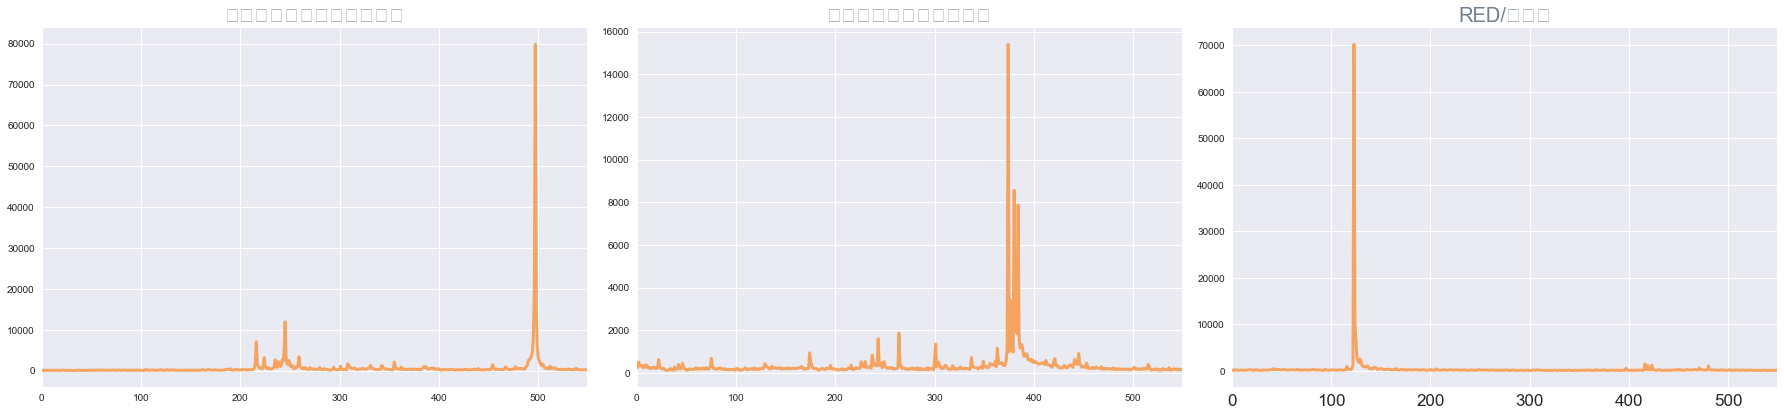

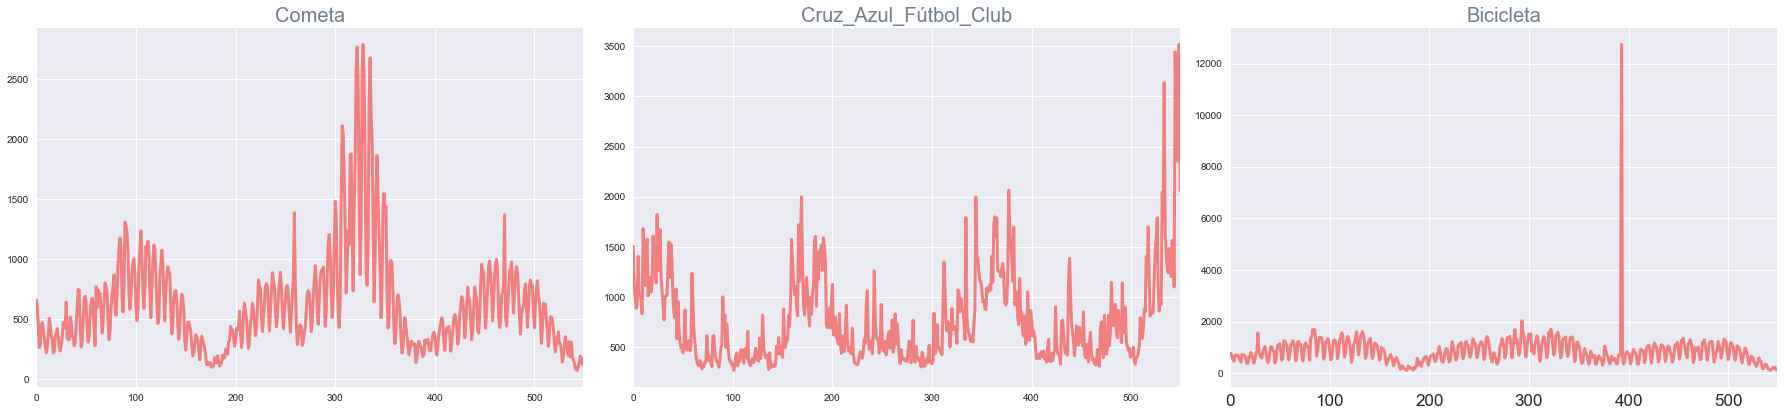

In [161]:
plt.style.use('seaborn')
#get random indices to plot
languages = newtrain['Language'].unique()
indices = np.random.randint(1,1400,size=3)
num_results = len(indices)
print(f'Indices chosen: {indices}')

#plot selected incides for each language 
colors = ['cadetblue','powderblue','steelblue','yellowgreen','darkseagreen','peachpuff','sandybrown','lightcoral']
dataframedict = {}
for i,language in enumerate(languages):
    dataframedict[language] = newtrain[newtrain['Language']==language]
    if language != 'na':
        langcolor = colors[i]
        fig, subaxes = plt.subplots(1,num_results,figsize=[25,6])
        pivottable = dataframedict[language].pivot_table(columns='Article')
        for i, index in enumerate(indices):
            singlerecord = pivottable.iloc[:,index]
            plt.xticks(fontsize=17)
            sns.tsplot(singlerecord,ax = subaxes[i],color=langcolor, linewidth=3)
            subaxes[i].set_title(singlerecord.name, color='slategray')
            subaxes[i].title.set_size(20)
            #fig.suptitle(language)
            plt.tight_layout()
    dataframedict[language]['Total'] = dataframedict[language].sum(axis=1)


#### Top 5 Pages per Language

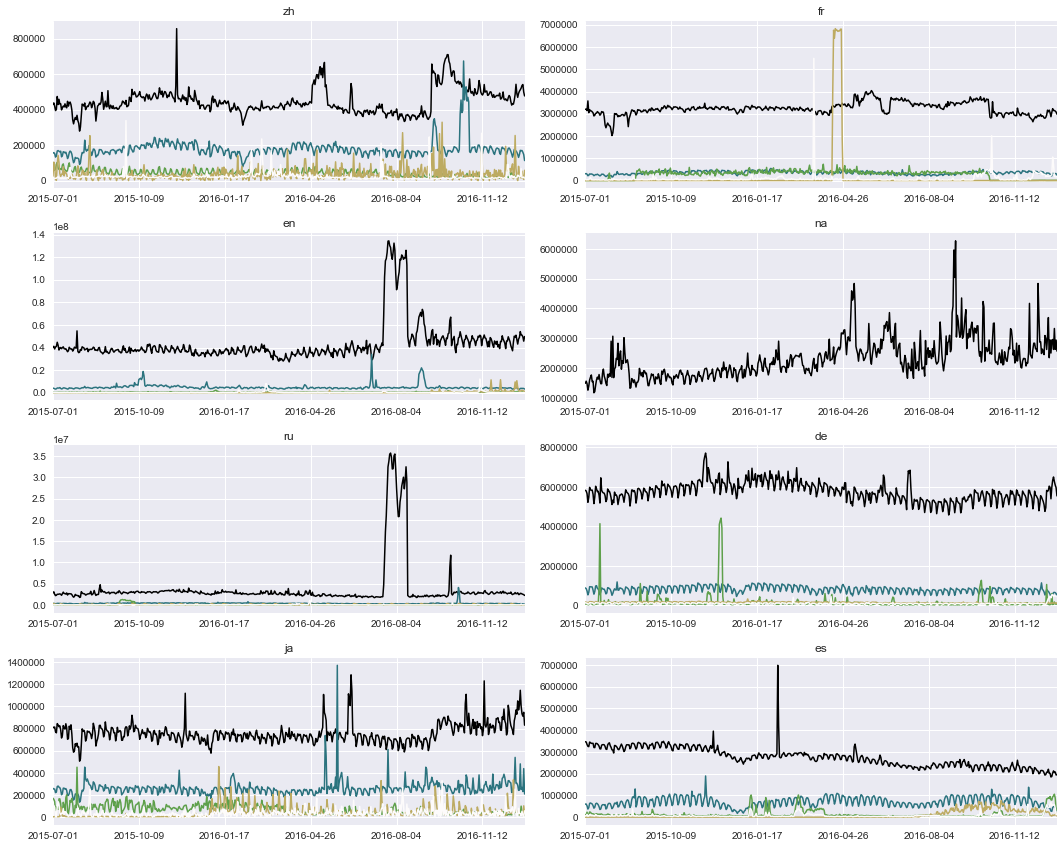

In [159]:
plt.style.use('seaborn')
fig, subaxes = plt.subplots(4,2,figsize=(15,12))
subaxes = subaxes.flatten()
x = [[a,b] for a in range(0,4) for b in range(0,2)]
for i,language in enumerate(languages):
    total_hits = dataframedict[language].groupby('Article').sum()
    top5sites = total_hits.nlargest(5, 'Total')
    axis = subaxes[x[i]]
    top5sites.T.iloc[:-1].plot(lw=1.5, ax=subaxes[i], colormap = 'gist_earth')
    subaxes[i].get_legend().remove()
    subaxes[i].set_title(language)
plt.tight_layout()

#### Page views by day of the month, day name, month

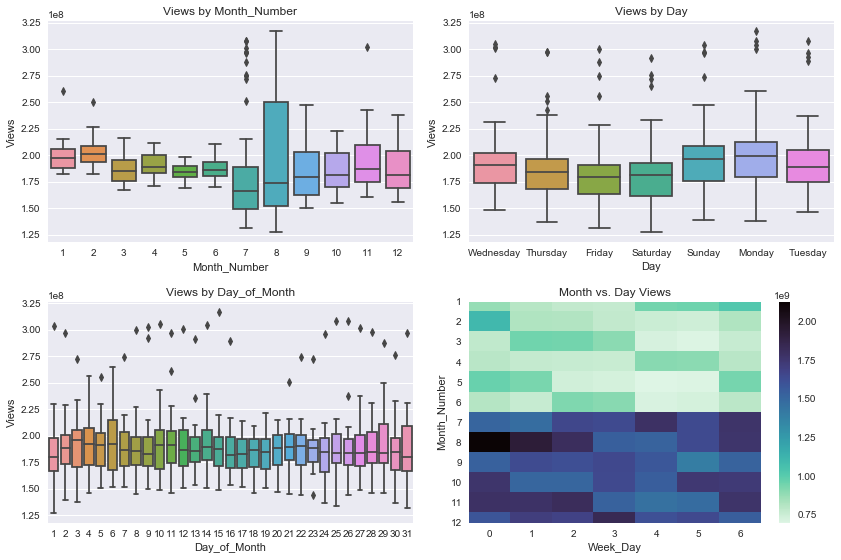

In [152]:
#add columns for date variables
newtrain_sum = newtrain.iloc[:,4:].sum()
newtrain_sum=newtrain_sum.to_frame().rename(columns={0:'Views'})
newtrain_sum.index=pd.DatetimeIndex(newtrain_sum.index)
newtrain_sum['Day'] = newtrain_sum.index.day_name()
newtrain_sum['Month'] = newtrain_sum.index.month_name()
newtrain_sum['Day_of_Month'] = newtrain_sum.index.day
newtrain_sum['Month_Number'] = newtrain_sum.index.month
#0 is for Monday, 6 is for Saturday
newtrain_sum['Week_Day'] = newtrain_sum.index.weekday

plt.style.use('seaborn')
fig, axes = plt.subplots(2,2,figsize=(12,8))
axes=axes.reshape(4)
graphs = ['Month_Number','Day','Day_of_Month']
for i, graph in enumerate(graphs):
    sns.boxplot(x=graph, y='Views', data=newtrain_sum, ax=axes[i])
    axes[i].set_title(f'Views by {graph}')
    plt.tight_layout()
    
month_day = newtrain_sum.groupby(['Month_Number','Week_Day'])['Views'].sum().unstack()
sns.heatmap(month_day, cmap = 'mako_r',ax=axes[3])
plt.xticks(rotation='horizontal')
plt.yticks(rotation='horizontal')
x=plt.title('Month vs. Day Views')

### 2. ARIMA Model

Many time series models assume stationarity of data, which means the series has 1) constant mean, 2) constant variance, and 3) lags are independent of each other. However, some of the records (if not most) in our dataset might not be stationary. ARIMA models can tackle this problem by combining an autoregressive model (AR) and a moving average model (MA) to transformed data - namely, the differenced time series by the order of "I" in "ARIMA". This differencing stationarizes the data and enables us to make meaningful predictions.

The TimeSeries class is used to calculate diagnostics, graph components of the time series, and fit an ARIMA model to the data. The Predictions class is a more pared-down version of the TimeSeries object used solely to make predictions for a given article and format the forecasts according to Kaggle's desired output.

In [165]:
class TimeSeries:
    def __init__(self, ts):
        self.ts = ts
        self.df = pd.DataFrame(ts).rename(columns={0:'Hits'})
        self.adf_statistic = self.stationarity_check()[0]
        self.pvalue = self.stationarity_check()[1]
        self.stationary = self.stationarity_check()[2]
        
    def stationarity_check(self):
        """Checks for stationarity of TimeSeries object. Returns adf_statistic, p-value of the null hypothesis being
        that the time series is not stationary, and a boolean indicating whether the time series is stationary."""
        ts = self.ts
        stationarity = adfuller(ts)
        adf_statistic = stationarity[0]
        pvalue = stationarity[1]
        if stationarity[0] < stationarity[4]['5%']:
            stationary = True
        else:
            stationary = False
        return adf_statistic, pvalue, stationary
            
    def plot_diffs(self):
        """
        Plots the ACF and PACF of the original time series, the time series differenced once, and the time series differenced twice.
        """
        plt.style.use('fivethirtyeight')
        ts = self.ts
        fig, axes = plt.subplots(3,3,figsize=(18,10))
        axes = axes.reshape(9,)
        for i in range(0,3):
            if i == 0:
                ts.plot(ax=axes[0], lw=2)
                plot_acf(ts, ax=axes[1])
                plot_pacf(ts, ax=axes[2])
                axes[0].set_title('Original Series')
            if i > 0:
                lag = ts.diff(i)
                axis_start = i**2+2
                lag.plot(ax=axes[axis_start], lw=2)
                plot_acf(lag[i:], ax=axes[axis_start+1])
                plot_pacf(lag[i:], ax=axes[axis_start+2])
                axes[axis_start].set_title('Lag of '+str(i))
            plt.tight_layout()
            
    def plot_rolling(self, n=12):
        """
        Plots the rolling average, rolling standard deviation, and original time series.
        """
        ts = self.ts
        fig, axes = plt.subplots(1,figsize=(10,4))
        ts.rolling(n).std().plot(color='darkseagreen', ax=axes, lw=2)
        ts.plot(ax=axes, color='lightcoral', lw=2)
        ts.rolling(n).mean().plot(ax=axes, lw=2)
        plt.title('Time Series with Rolling Statistics')
        legend = axes.legend(['Rolling Std.','Original','Rolling Avg.'])
        
    def decompose(self, zoom=True):
        """
        Decomposes time series into trend, seasonal effects, and residuals, and graphs each of these components.
        """
        ts = self.ts
        mul_result = seasonal_decompose(ts, model = 'multiplicative', period=7)
        plt.rcParams['figure.figsize'] = (10,4)
        fig = mul_result.plot().suptitle('Multiplicative')
        add_result = seasonal_decompose(ts, model = 'additive', period=7)
        if zoom:
            df = mul_result.seasonal.to_frame()
            df['day'] = df.index.day_name()
            df.index = df['day']
            df.drop('day',axis=1,inplace=True)
            fig = df[0:15].plot(kind='bar', figsize=(11,3), color='darkseagreen') 
            plt.title('Seasonal Trend')
            fig.get_legend().remove()
        return mul_result, add_result
            
    def auto_arima(self):
        """
        Use the auto_arima function to automatically detect the p, d, and q parameters of the ARIMA model for us. 
        Display the summary of the ARIMA model and print the mean error, percent error, and symmetric mean percent error (SMAPE).
        """
        ts = self.ts
        train, test = train_test_split(ts, test_size = 0.25)

        autoarima = pm.auto_arima(train, start_p=0, start_q=0, d=None, max_p=3, max_q=3, max_order=5,
                    m=7, seasonal=True, stepwise=True)

        train.plot(lw=3, label='actual train')
        test.plot(lw=3, label= 'actual test', color='yellowgreen')
        predictions, confint = autoarima.predict(test.shape[0], return_conf_int=True)

        predictions_series = pd.Series(predictions, index = test.index)
        predictions_series.plot(lw=3, color='orangered', label='predictions')
        fitted_series = pd.Series(autoarima.predict_in_sample(start=0, end=train.shape[0]-1), index = train.index)
        fitted_series.plot(lw=3, color='orangered', label='fitted')
        lower_series = pd.Series(confint[:, 0], index=test.index)
        upper_series = pd.Series(confint[:, 1], index=test.index)
        plt.fill_between(lower_series.index, lower_series, upper_series, color='gray',alpha=0.25)
        plt.legend(loc='upper left')
        
        display(autoarima.summary())
        fig = autoarima.plot_diagnostics(figsize=(10,6))
        plt.tight_layout()
    
        squared_error = mean_squared_error(test, predictions_series)
        mean_error = np.sqrt(squared_error)
        percent_error = mean_error/ts.mean()
        smape_value = smape(test, predictions_series)
        print(f'''
        mean error: {mean_error}
        percent_error: {percent_error}
        smape: {smape_value}''')
        return mean_error, percent_error, smape_value

In [155]:
#function to make a dataframe for any article
def make_df_article(article):
    totals = newtrain[newtrain['Article']==article].sum()
    rows = totals[4:-1].astype(float)
    rows.index = pd.DatetimeIndex(rows.index)
    return rows

# def make_df_page(page):
#     totals = newtrain[newtrain['Page']==page].sum()
#     rows = totals[4:-1].astype(float)
#     rows.index = pd.DatetimeIndex(rows.index)
#     return rows

#create timeseries object
myseries = make_df_article('Bill_Nye')
timeseries = TimeSeries(myseries)

adf: -9.638212792381553, 
p-value: 1.5459408542225872e-16,
stationary: True


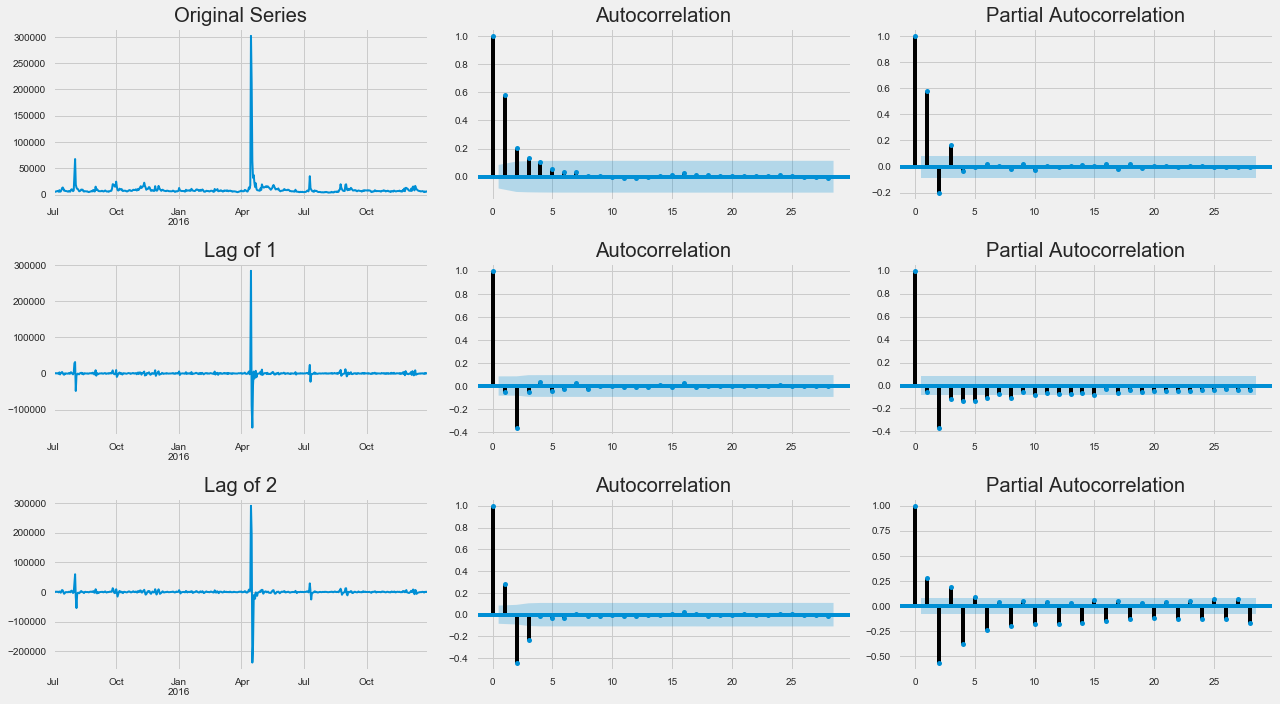

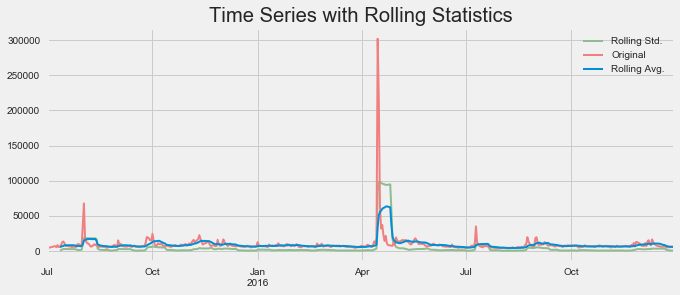

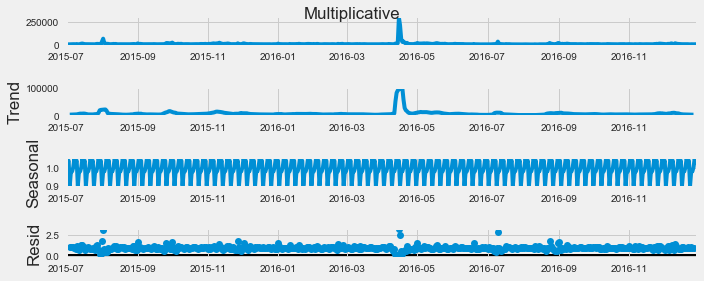

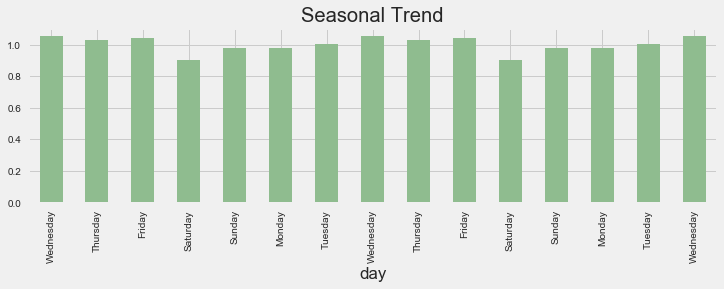

In [162]:
#call each method on the time series object
adf_statistic, pvalue, stationary = timeseries.stationarity_check()
print(f'''adf: {adf_statistic:}, 
p-value: {pvalue},
stationary: {stationary}''')
pd.plotting.register_matplotlib_converters()
timeseries.plot_diffs()
timeseries.plot_rolling()
mul, add = timeseries.decompose()

#### Summary of ARIMA model

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  411
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -4525.924
Date:                Tue, 24 Mar 2020   AIC                           9061.848
Time:                        16:13:51   BIC                           9081.941
Sample:                             0   HQIC                          9069.797
                                - 411                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4378.1782   3711.318      1.180      0.238   -2895.871    1.17e+04
ar.L1          0.5603      0.329      1.703      0.089      -0.085       1.205
ma.L1          0.1646      0.347      0.474      0.635      -0.515       0.844
ma.L2         -0.1871      0.264     -0.709      0.478      -0.704       0.330
sigma2      2.187e+08      2.649   8.26e+07      0.000    2.19e+08    2.19e+08
===================================================================================
Ljung-Box (Q):                        3.25   Jarque-Bera (JB):           2132387.23
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              22.19   Skew:                            18.18
Prob(H) (two-sided):                  0.00   Kurtosis:                       353.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.52e+22. Standard errors may be unstable.
"""


        mean error: 3424.6226995253683
        percent_error: 0.3648484823040032
        smape: 35.47616059385218


(3424.6226995253683, 0.3648484823040032, 35.47616059385218)

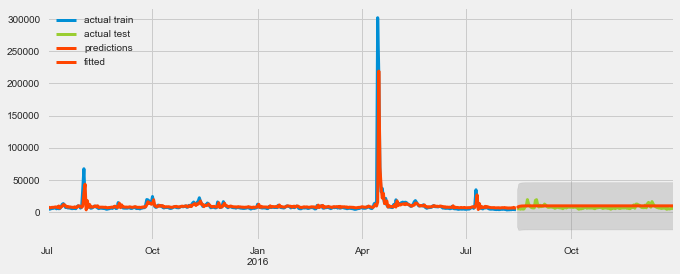

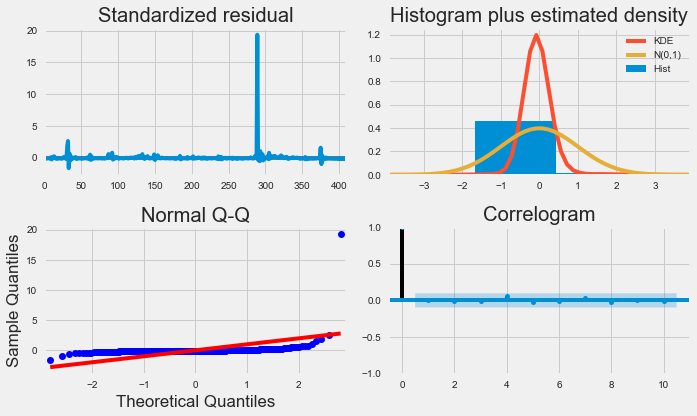

In [163]:
timeseries.auto_arima()

In [17]:
submission_key = pd.merge(submission, key)
datelist = pd.date_range('2017-01-01', periods=60).date.tolist()

class TSPrediction:
    def __init__(self, page):
        self.page = page
        self.ts = self.transform()
        self.test = self.make_predictions()[0]
        self.train = self.make_predictions()[1]
        self.autoarima = self.make_predictions()[2]
        self.predictions = self.make_predictions()[3]
        
    def transform(self):
        page = self.page
        ts = newtrain[newtrain['Page']==page]
        transposed = ts.T.iloc[4:]
        transposed.columns = ['Hits']
        return transposed
        
    def make_predictions(self):
        ts = self.ts
        page = self.page
        test, train = train_test_split(ts, test_size = 0.25)
        autoarima = pm.auto_arima(ts, start_p=0, start_q=0, d=None, max_p=3, max_q=3, max_order=5,
                    m=7, seasonal=True, stepwise = True)
        predictions = autoarima.predict(60)
        predictions = pd.DataFrame(predictions, index = datelist).rename(columns={0:'Predicted'})
        predictions['Page'] = [page + '_' + str(x) for x in predictions.index]
        return train, test, autoarima, predictions[['Page','Predicted']]

In [18]:
submission_key.head()

,Id,Visits,Page
0,bf4edcf969af,0,!vote_en.wikipedia.org_all-access_all-agents_2...
1,929ed2bf52b9,0,!vote_en.wikipedia.org_all-access_all-agents_2...
2,ff29d0f51d5c,0,!vote_en.wikipedia.org_all-access_all-agents_2...
3,e98873359be6,0,!vote_en.wikipedia.org_all-access_all-agents_2...
4,fa012434263a,0,!vote_en.wikipedia.org_all-access_all-agents_2...


In [19]:
pages = newtrain['Page']
submission_data = pd.DataFrame()

for i,page in (enumerate(pages)):
    if i<2:
        timeseries = TSPrediction(page)
        predicted_values = timeseries.predictions
        second_train_page = second_train[second_train['Page']==page].iloc[:,1:].T
        second_train_page.index = pd.DatetimeIndex(second_train_page.index)
        second_train_dates = second_train_page.loc['2017-01-01':'2017-03-01']
        second_train_dates.columns = ['Actual']
        predicted_df = pd.concat([predicted_values, second_train_dates],axis=1)
        submission_data = submission_data.append(predicted_df[['Page','Predicted','Actual']])
        
submission_data['Article'] = [x[0:len(x)-11] for x in submission_data['Page']]

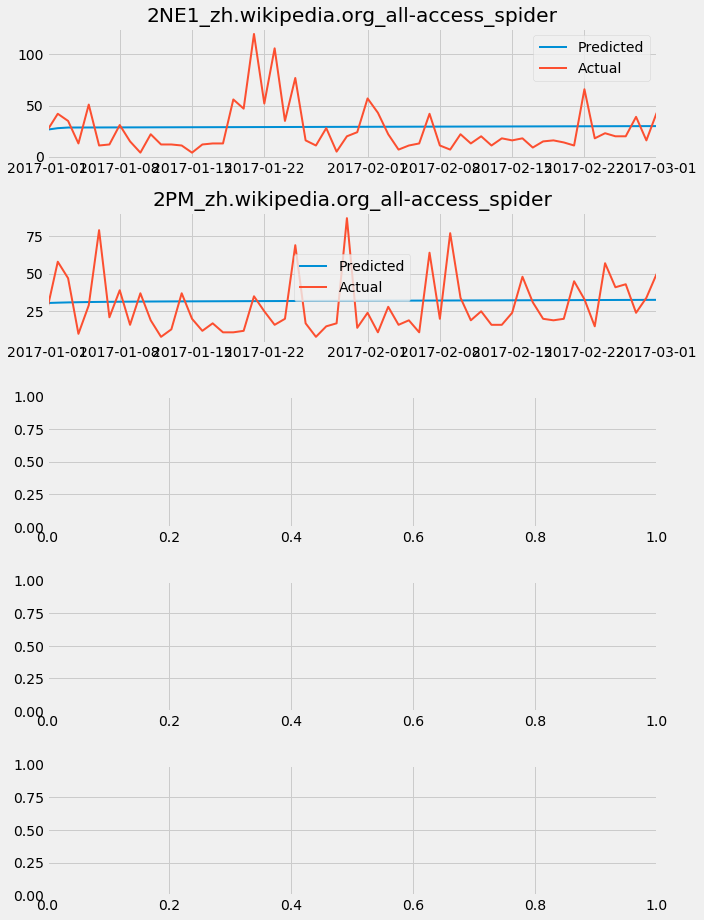

In [20]:
fig, axes = plt.subplots(5,1,figsize=(10,13))

for i,article in enumerate(submission_data['Article'].unique()):
    plotting = submission_data[submission_data['Article']==article]
    plotting[['Predicted','Actual']].plot(ax=axes[i],lw=2)
    axes[i].set_title(article)
plt.tight_layout()

In [21]:
smape(submission_data['Actual'],submission_data['Predicted'])

59.291750417620825

In [22]:
submission_data.head()
final_submission = pd.merge(submission_key, submission_data, how='inner',on='Page')
final_submission = final_submission[['Id','Predicted','Actual']]
final_submission.head()

,Id,Predicted,Actual
0,ff8c1aade3de,26.517722,26.0
1,6a4de5b43179,27.934241,42.0
2,559a1ab24535,28.565121,35.0
3,8bd4a4dea5a3,28.589668,13.0
4,fb31ab105824,28.614215,51.0


### Exploratory Modeling - Prophet


### Questions:
- how to parallelize code
- how to optimize / improve prophet and arima results
- what other time series models are there?
- "falling back to newton" error when trying to add metrics
- how to i optimize my prophet model / know what changepoint prior scale to use, etc? calculate for diff combos and choose lowest error?

In [251]:
language_countries = {'fr':[holidays.France(years=[2015,2016]), holidays.Belgium(years=[2015,2016])],
                     'en':[holidays.UnitedStates(years=[2015,2016])],
                     'ru':[holidays.Russia(years=[2015,2016])],
                     'ja':[holidays.Japan(years=[2015,2016])],
                     'es':[holidays.Spain(years=[2015,2016])]}

def make_prophet_df(page):
    """
    Creates a dataframe with 'ds' and 'y' columns, as required for the Prophet model.
    Input is the full title of the wikipedia page, including article name, language, and access.
    """
    df = orig_train[orig_train['Page']==page].iloc[:,1:].T
    df = df.reset_index()
    df.columns = ['ds','y']
    return df


def remove_outliers(prophet_df):
    """
    Removes outliers from by deleting any records with a value below Q1-1.5(IQR) or above Q3+1.5(IQR). 
    Input is a dataframe with 'ds' and 'y' columns.
    """
    Q3 = prophet_df['y'].quantile(0.75)
    Q1 = prophet_df['y'].quantile(0.25)
    IQR = Q3-Q1
    df_no_outliers = prophet_df.loc[prophet_df['y'].between(Q1-1.5*IQR, Q3+1.5*IQR)]
    num_outliers = sum(prophet_df['y'].between(Q1-1.5*IQR, Q3+1.5*IQR)==False)
    print (f'{num_outliers} outliers removed')
    return df_no_outliers


def holiday_df(language):
    """
    Creates a dataframe of holidays for countries speaking the given language.
    """
    all_holidays = pd.DataFrame()
    holiday_items = language_countries[language]
    for i,item in enumerate(holiday_items):
        holiday_df = pd.DataFrame(sorted(holiday_items[i].items()))
        all_holidays = all_holidays.append(holiday_df)
    all_holidays.rename(columns={0:'ds',1:'holiday'},inplace=True)
    all_holidays.reset_index(inplace=True,drop=True)
    return all_holidays


def plot_holidays(holidays_df, original, **kwargs):
    """
    Plots original time series and time series with no outliers, with dashed markers for holidays.
    """
    pd.plotting.register_matplotlib_converters()
    fig, axes = plt.subplots(1,2,figsize=(12,3), sharex=True)
    #convert index to dates, plot
    original.index = pd.to_datetime(original['ds'])
    orig = original['y'].plot(ax=axes[0])
    for date in holidays_df['ds']:
        orig.axvline(x=date, color='green', alpha = 0.3, ls='--')
    orig.set_title('Original')
    
    if kwargs:
        no_outliers.index = pd.to_datetime(no_outliers['ds'])
        cleaned = no_outliers['y'].plot(ax=axes[1])
        for date in holidays_df['ds']:
            cleaned.axvline(x=date, color='green', alpha = 0.3, ls='--')
        cleaned.set_title('No Outliers')

        
def fit_prophet(df, holiday_df, diagnostics=False):
    """
    Fits prophet model on a dataframe with 'ds' and 'y' columns for a range of changepoint prior scales.
    Plots fitted values and forecasts for each changepoint prior scale. 
    Returns table of forecasts.
    """
    marker = int(df.shape[0]*0.75)
    train = df[0:marker]
    test = df[marker:]
    
    if diagnostics:
        fig, axes_forecast = plt.subplots(2,2,figsize=(13,6))
        axes_forecast=axes_forecast.reshape(-1)

        fig, axes_metrics = plt.subplots(2,2,figsize=(13,6))
        axes_metrics=axes_metrics.reshape(-1)
        total_metrics = pd.DataFrame()
    
    all_forecasts=pd.DataFrame()
    for i, changepoint in enumerate([0.01, 0.5, 10, 30]):
        prophet = Prophet(changepoint_prior_scale=changepoint, holidays=holiday_df).fit(train)
        future = prophet.make_future_dataframe(periods=len(test)+80)
        forecast = prophet.predict(future)
        forecast['changepoint'] = changepoint
        all_forecasts = all_forecasts.append(forecast)
        if not diagnostics:
            return all_forecasts
        else:
            #plot forecasts
            fig1 = prophet.plot(forecast,ax=axes_forecast[i])
            axes_forecast[i].set_title(changepoint)
            a = add_changepoints_to_plot(axes_forecast[i], prophet, forecast)

            #plot components
#             fig = prophet.plot_components(forecast, figsize=(7,5))
#             plt.tight_layout()

            #return metrics
            prophet_cv = cross_validation(prophet, horizon='60 days')
            metrics = performance_metrics(prophet_cv)
            metrics['changepoint'] = changepoint
            fig=plot_cross_validation_metric(prophet_cv, metric='mape', figsize=(7,3), ax=axes_metrics[i])
            axes_metrics[i].set_title(changepoint)
            total_metrics = total_metrics.append(metrics)
            total_metrics['days'] = [int(str(x)[0:(len(str(x)))-14]) for x in total_metrics['horizon']]
    return forecast, total_metrics


def predictions(df, holiday_df, metrics):
    changepoint_mape = metrics.groupby('changepoint')['mape'].mean()
    best_changepoint = changepoint_mape.idxmin()
    best_mape = changepoint_mape.min()
    print(f'changepoint chosen: {best_changepoint}')
    print(f'best average mape: {best_mape}')
    prophet = Prophet(holidays=holiday_df, changepoint_prior_scale=best_changepoint).fit(df)
    future = prophet.make_future_dataframe(60)
    forecast = prophet.predict(future)
    return forecast


def compare_actuals(forecast, page):
    """
    Create dataframe of actuals vs. predicted for 7/1/2015 to 3/1/2016.
    """
    pd.plotting.register_matplotlib_converters()
    actual = second_train[second_train['Page']==page].T[1:]
    actual.index = pd.to_datetime(actual.index)
    forecast = forecast[['ds','yhat']]
    actual_predicted = pd.merge(actual, forecast, how='outer', left_index=True, right_on='ds')
    actual_predicted.index=actual_predicted['ds']
    actual_predicted.drop('ds',axis=1,inplace=True)
    actual_predicted.columns = ['actual','predicted']
    actual_predicted['actual'] = actual_predicted['actual'].astype(float)
    actual_predicted.plot(lw=2, figsize=(5,3))
    plt.title('Actual vs. Predicted')
    return actual_predicted


def smape(df):
    """
    Calculate SMAPE of model for test days in question, as determined by Kaggle competition outline (https://www.kaggle.com/c/web-traffic-time-series-forecasting/data)
    """
    test_days = df.loc['2017-01-01':'2017-03-01']
    return 100/len(test_days['actual']) * np.sum(2 * np.abs(test_days['predicted'] - test_days['actual']) / (np.abs(test_days['actual']) + np.abs(test_days['predicted'])))


def submission(predicted, page):
    """
    Make dataframe of final submission for given page
    """
    submission_dates = predicted[['ds','yhat']]
    submission_dates['Page']=page+'_'+submission_dates['ds'].astype(str)
    submission_key = pd.merge(submission_dates, key, how='inner')
    final_submission = submission_key[['Id','yhat']]
    final_submission.columns = ['Id','Visits']
    return final_submission

57 outliers removed
changepoint chosen: 0.5
best average mape: 0.5737290981123194
smape for test days: 37.4332404932327


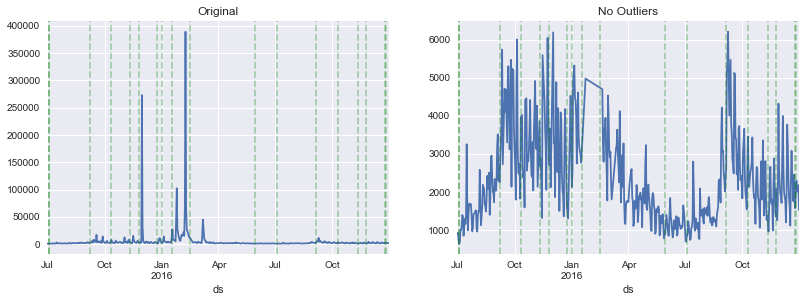

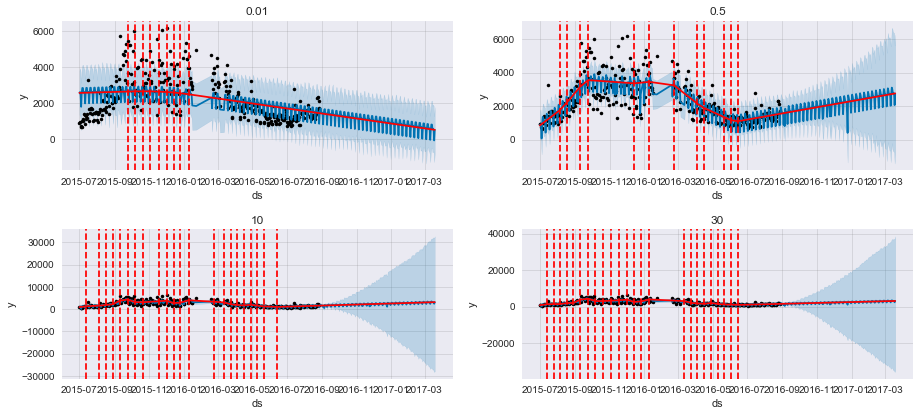

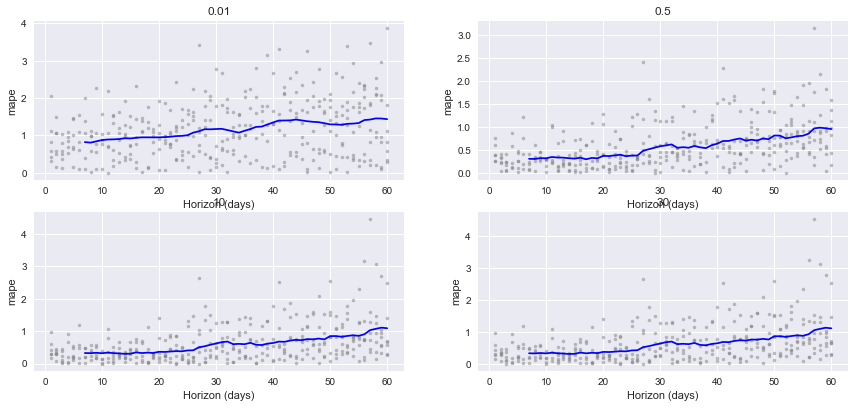

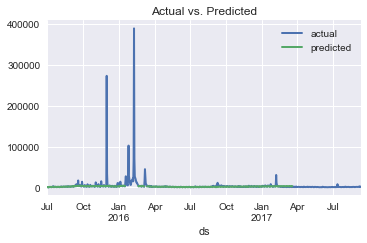

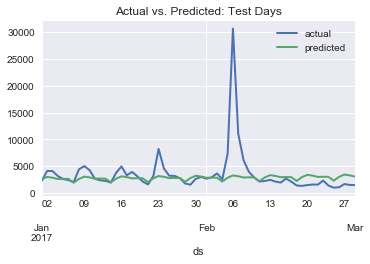

In [252]:
#call each of the prophet functions on a sample page
#make the prophet dataframe
plt.style.use('seaborn')
page = 'Peyton_Manning_en.wikipedia.org_desktop_all-agents'
prophet_df = make_prophet_df(page)

#remove outliers
no_outliers = remove_outliers(prophet_df)

#create dataframe of american holidays
holidays_en = holiday_df('en')

#plot original and cleaned time series against holidays
plot_holidays(holidays_en, prophet_df, no_outliers=cleaned_df)

#plot forecasts for original and cleaned time series
forecast_cleaned, metrics_cleaned = fit_prophet(no_outliers, holidays_en, diagnostics=True)

#calculate evaluation metrics for different changepoints
predicted = predictions(no_outliers, holidays_en, metrics_cleaned)

#pick best changepoint and make predictions until march 2017 for submission
comparison = compare_actuals(forecast_cleaned, page)

#plot predicted vs. actual for test days
comparison.loc['2017-01-01':'2017-03-01'].plot(lw=2, figsize=(6,3))
plt.title('Actual vs. Predicted: Test Days')

#calculate smape of test days
print(f'smape for test days: {smape(comparison)}')

#create submission for page
final_submission = submission(predicted, page)

In [255]:
final_submission.head()

,Id,Visits
0,776952009727,1939.664944
1,19827755e2f1,2469.416785
2,f2c67a1993b6,2167.312381
3,084ea7c0fda1,1874.558555
4,5ca46b70660d,1872.027734
